
Class Balance:
Promovare
1    250
0    250
Name: count, dtype: int64

Proportii: 0.50 - 0.50


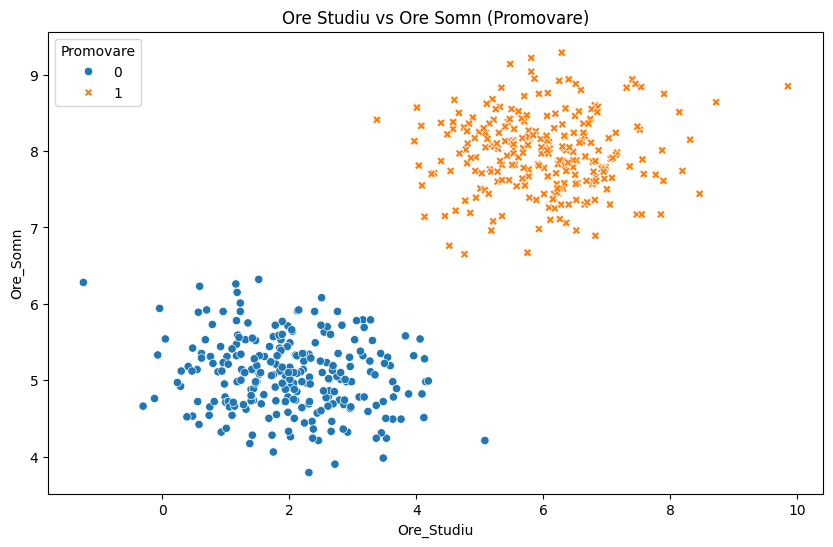

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm

# a)

df = pd.read_csv('date_promovare_examen.csv')
print("\nClass Balance:")
print(df['Promovare'].value_counts())

counts = df['Promovare'].value_counts()
print(f"\nProportii: {counts[0] / len(df):.2f} - {counts[1] / len(df):.2f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Ore_Studiu', y='Ore_Somn', hue='Promovare', style='Promovare')
plt.title('Ore Studiu vs Ore Somn (Promovare)')
plt.savefig('scatter_plot.png')

#b) se poate observa ca datele sunt separabile liniar (exista o linie care separa cele doua clase), deci
# sunt bine separate. Voi face si separatorul liniar generat de regresia logistica.

# 

In [20]:
attr = df[["Ore_Studiu", "Ore_Somn"]].values
tag = df["Promovare"].values

# standardizare
attr_mean = attr.mean(axis=0)
attr_std = attr.std(axis=0)
attr = (attr - attr_mean) / attr_std


In [21]:
with pm.Model() as model:

    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5, shape=2)


    logits = alpha + pm.math.dot(attr, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=tag)

    trace = pm.sample(
        2000,
        tune=2000,
        chains=2,
        target_accept=0.9
    )

# granita de decizie o sa fie beta1*x1 + beta2*x2 + alpha = 0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1161 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [22]:
import arviz as az
az.summary(trace, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.466,1.442,-2.292,3.103,0.041,0.030,1254.0,1090.0,1.0
beta[0],5.237,2.187,1.321,9.337,0.058,0.037,1441.0,1423.0,1.0
beta[1],8.139,2.573,3.677,13.092,0.071,0.056,1395.0,1351.0,1.0


In [23]:
alpha_mean = trace.posterior["alpha"].mean().item()
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw")).values

x_vals = np.linspace(
    df["Ore_Studiu"].min(),
    df["Ore_Studiu"].max(),
    200
)

# conversie inapoi din standardizare pentru a afisa datele originale pe grafic
x1_scaled = (x_vals - attr_mean[0]) / attr_std[0]
x2_scaled = -(alpha_mean + beta_mean[0]*x1_scaled) / beta_mean[1]
x2_vals = x2_scaled * attr_std[1] + attr_mean[1]


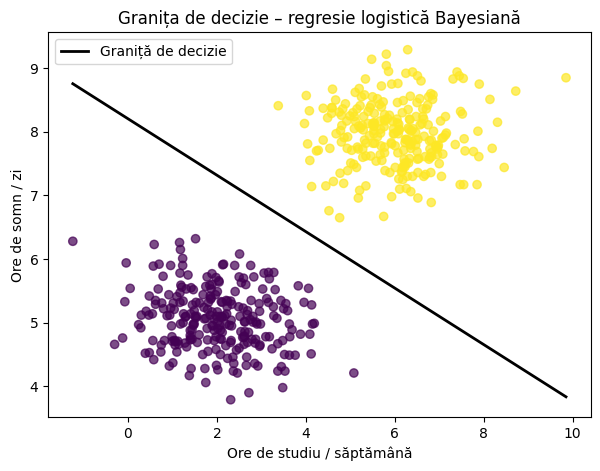

In [24]:
plt.figure(figsize=(7,5))
plt.scatter(
    df["Ore_Studiu"],
    df["Ore_Somn"],
    c=tag,
    alpha=0.7
)
plt.plot(
    x_vals,
    x2_vals,
    color="black",
    linewidth=2,
    label="Graniță de decizie"
)

plt.xlabel("Ore de studiu / săptămână")
plt.ylabel("Ore de somn / zi")
plt.title("Granița de decizie – regresie logistică Bayesiană")
plt.legend()
plt.show()


In [25]:
# c) Cred ca orele de somn influenteaza mai mult promovabilitatea pentru ca:

# 1. exista destui studenti cu acelasi numar de ore de studiu, dar care au picat
# 2. nu exista studenti care au promovat cu mai putin de 6.5 ore de somn, oricat ar fi invatat